# Robust estimation and prediction of extragalactic distance errors in HyperLEDA

Companion notebook for the "Predicting extragalactic distance errors using bayesian inference in multi measurement catalogues" paper, Monthly Notices of the Royal Astronomical Society, Volume 485, Issue 3, May 2019, Pages 4343–4358, https://doi.org/10.1093/mnras/stz615

This notebook shows:

- A bootstrap robust estimation of all distance errors (H,M) and frequentist distance errors (P,Q) in HyperLEDA
- An analysis of the distribution of errors
- An analysis of no-error measurements in HyperLEDA
- A prediction of TFR errors for no-error galaxies in HyperLEDA, based on the posterior sample results from the NED-D TFR error models in [this notebook](prediction_error.ipynb)
- An analysis of the asymmetry in bootstrap errors

In [ ]:
%%bash
# download the original 2018 HyperLEDA database
wget https://github.com/saint-germain/anisotropias/raw/master/HyperLeda_a007_full.txt

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import seaborn as sns
%matplotlib inline
pd.options.mode.chained_assignment = None
#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=12, usetex=True)
sns.set()
sns.set_style("whitegrid")
current_palette = sns.color_palette()

In [2]:
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.
    Richard M. Brugger, "A Note on Unbiased Estimation of the Standard Deviation", The American Statistician (23) 4 p. 32 (1969)

    values, weights -- Numpy ndarrays with the same shape.
    """
    n=len(values)
    average = np.average(values, weights=weights)
    variance = (n/(n-1.5))*np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return np.sqrt(variance),average

In [3]:
# This section organizes the HyperLEDA data
df=pd.read_csv('HyperLeda_a007_full.txt',skiprows=19,skipfooter=5,names=['objname','j2000','modulus','distance','modc','method','ire','bibref','bibcode','calib'])
df['mod']=np.array([i[0:5] for i in np.array(df.modulus,dtype='str')],dtype='float')
df['err']=np.array([i[6:10] for i in np.array(df.modulus,dtype='str')])
df=df.replace('    ',np.nan)
df.err=df.err.astype(float)
filter=(np.isnan(df.err))|(df.err==0)
elist=np.unique(df.objname[filter]) # list of no-error galaxies
df1=df[~filter]
namelist=np.unique(df1.objname)
print('Galaxies in database is %i' % len(np.unique(df.objname)) )
print('Galaxies with distance measurements without reported errors is %i' % len(elist) )

Galaxies in database is 4224
Galaxies with distance measurements without reported errors is 1064


/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


### Computation of H,M,P,Q errors

In [12]:
%%time
np.random.seed(10)
nbins=10000 # 1e4 -> 1 minutes
em=[] # number of measurements per galaxy
bootp50=[] # H error
bootsig=[] # variance of H error
dboot=[] # mean bootstrap distance
bootmad=[] # M error: median absolute deviation (robust)
boot84=[] # median 84th percentile bootstrap distance
boot16=[] # median 16th percentile bootstrap distance
ecf=[] # P error - propagation
eqd=[] # Q error - quadrature sum of P and weighted stdev
pos=[] # coordinates
gal=[] # galaxy ID

for i in namelist:
    dfilter=np.in1d(df1['objname'],i)
    dummy=df1[dfilter]
    if len(dummy)>1:
        em+=[len(dummy)] # n_meas, number of measurements per galaxy
        pos+=[dummy.j2000.iloc[0]]
        gal+=[dummy.objname.iloc[0]]
        tli=[]
        for km,ke in zip(dummy['modc'],dummy['err']):
            tli+=[list(10**(np.random.normal(km,ke,nbins)/5.+1))] # bootstrap draw for each gal
        tli=np.array(tli)
        b84=np.percentile(tli, 84,axis=0)
        b16=np.percentile(tli, 16,axis=0)
        boot84+=[np.median(b84)/1e6] # Hmax
        boot16+=[np.median(b16)/1e6] # Hmin
        booterr=(b84-b16)/2 # sigma draws from bootstrap for each gal
        bootmean=np.median(tli,axis=0) # mean draws from bootstrap for each gal
        bootp50+=[np.median(booterr)/1e6] # mean bootstrap error
        bootsig+=[((np.percentile(booterr, 84)-np.percentile(booterr, 16)))/2e6] # the error of the error
        bootmad+=[np.median(np.abs(tli - np.median(tli)))/1e6]
        dboot+=[np.median(bootmean)/1e6] # bootstrap mean D
        wnat,avnat = weighted_std(dummy['modc'],1/dummy['err']**2)
        distwav=10**(avnat/5+1)/1e6
        wsti=0.461*distwav*wnat # weighted standard deviation
        ecfi=0.461*distwav/np.sqrt((1/dummy['err']**2).sum()) # error according to cosmicflows
        ecf+=[ecfi]
        eqd+=[np.sqrt(ecfi**2+wsti**2)]  

CPU times: user 26.5 s, sys: 116 ms, total: 26.6 s
Wall time: 27.9 s


### Do not re-write bootstrap results by executing the next cell. For emergencies only!

In [96]:
d = {'objname': gal,'j2000':pos, 'meas': em, 'H (Mpc)':bootp50, 'D (Mpc)':dboot,'P (Mpc)':ecf,'Q (Mpc)':eqd,'M (Mpc)':bootmad,'Dmin (Mpc)':boot16,'Dmax (Mpc)':boot84}
dfb = pd.DataFrame(data=d)
dfb.to_csv("hl_bootstrap_results.csv")

## Analysis of HyperLEDA errors

In [12]:
# The pre-computed NED-D errors are available from the local repository
dfb=pd.read_csv('hl_bootstrap_results.csv')
em=dfb.meas
dboot=dfb['D (Mpc)']
bootp50=dfb['H (Mpc)']
ecf=dfb['P (Mpc)']
eqd=dfb['Q (Mpc)']
bootmad=dfb['M (Mpc)']
boot84=dfb['Dmax (Mpc)']
boot16=dfb['Dmin (Mpc)']
print('Galaxies with errors and more than 1 measurement is %i' % len(em) )

Galaxies with errors and more than 1 measurement is 2456


## The following plots show how the pre-computed error trends are distributed

/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Normalized counts')

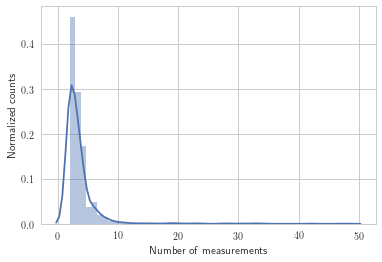

In [11]:
filt=np.array(em)<3
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]
sns.distplot(em) 
plt.xlabel('Number of measurements')
plt.ylabel('Normalized counts')

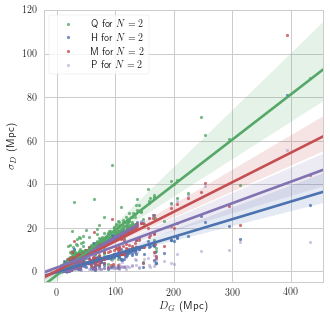

In [102]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1], scatter_kws={'alpha':0.8,'s':10},label='Q for $N=2$') # green, quadrature
sns.regplot(x,y,color=current_palette[0],label=r'H for $N=2$', scatter_kws={'s':10})
sns.regplot(x,z,color=current_palette[2],label='M for $N=2$', scatter_kws={'alpha':0.8,'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $N=2$') # red, cosmicflows
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.ylim(-5,120)

(-5, 120)

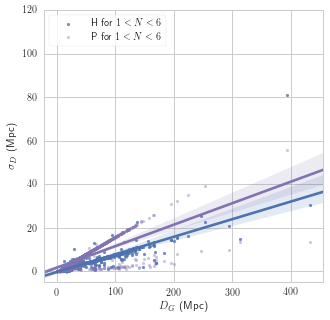

In [103]:
plt.figure(figsize=(5,5))
sns.regplot(x,y,color=current_palette[0],label=r'H for $1<N<6$', scatter_kws={'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $1<N<6$') # red, cosmicflows
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.ylim(-5,120)

In [18]:
filt=np.array(em)>2
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]

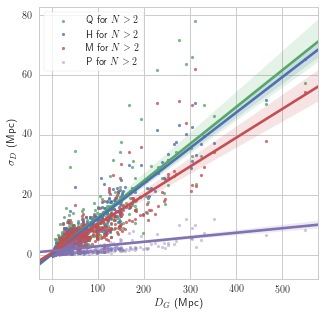

In [106]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1], scatter_kws={'alpha':0.8,'s':10},label='Q for $N>2$') # green, quadrature
sns.regplot(x,y,color=current_palette[0],label=r'H for $N>2$', scatter_kws={'s':10})
sns.regplot(x,z,color=current_palette[2],label='M for $N>2$', scatter_kws={'alpha':0.8,'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $N>2$') # red, cosmicflows
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')

(-27.566415177737486, 578.15288128834663)

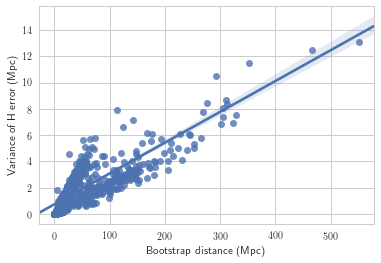

In [19]:
# Variance of H error plot
# This shows a similar linear trend as in the NED-D bootstrap results
# This only works if bootstrap is done within the notebook (bootsig is not in the database file)
ee=np.array(bootsig)[filt] 
sns.regplot(x,ee)
plt.xlabel('Bootstrap distance (Mpc)')
plt.ylabel('Variance of H error (Mpc)')

# Analysis and predictions for no-error galaxies in HyperLEDA

Here is the prediction of errors for galaxies in HyperLEDA that do not report a TF error measurement. This prediction is done using the posterior sample results from the NED-D TFR error models in [this notebook](prediction_error.ipynb).

In [ ]:
%%bash
# Here we download the pre-computed TFR posterior samples required to predict missing errors
# and the database of unreported TFR errors in NED-D
# This is not required if the computing_errors.ipynb and bayesian_models.ipynb notebooks were run locally
wget https://github.com/saint-germain/anisotropias/raw/master/posterior_lm.txt
wget https://github.com/saint-germain/anisotropias/raw/master/posterior_lh.txt
wget https://github.com/saint-germain/anisotropias/raw/master/bootstrap_results_2018.csv

In [6]:
# Select no-error galaxies
odf=df[df.method=='TF        '] 
filter=(np.isnan(odf.err))|(odf.err==0)
odf=odf[filter]
oelist=np.unique(odf.objname)
print('No. of Galaxies without reported TF errors is %i' % len(oelist) )

No. of Galaxies without reported TF errors is 203


In [7]:
# Calculate the median distance reported in those measurements
meddist=[]
for i in oelist:
    dummy=odf[odf['objname']==i]
    meddist+=[np.median(10**(dummy.modc/5+1)/1e6)]
meddist=np.array(meddist)

In [8]:
#Here we read the results from the pre-computed distance and distance errors
ndf=pd.read_csv("bootstrap_results_2018.csv")

em=ndf.meas # number of measurements

# Bootstrap (bootstrap-sampled distance posterior distribution) quantities:
dboot=ndf.dboot # bootstrap median distance (Mpc)
bootp50=ndf.bootp50 # H error (half of bootstrap 84th-16th distance percentile) (Mpc)
bootmad=ndf.bootmad # M error (Median Absolute Deviation of bootstrap) (Mpc)
# we recover the data used in the succesful bayesian linear model for H/M errors
# we filter using the lowest limiting number of measurements per galaxy for which the model is validated
# nhmax is 15 and  nmmax is 13 (from the bayesian_model notebook)
# this yields a filter for the minimum and maximum working range for each model
nhmax=15
filt=np.array(em)>nhmax
x1=np.array(dboot)[filt]
y1=np.array(bootp50)[filt]
filt1=(meddist<x1.max())&(meddist>x1.min())
print('Galaxies in range for H model: ',(filt1).sum()) 
nmmax=13
filt=np.array(em)>nmmax
x2=np.array(dboot)[filt]
y2=np.array(bootmad)[filt]
filt2=(meddist<x2.max())&(meddist>x2.min())
print('Galaxies in range for M model: ',(filt2).sum()) 

Galaxies in range for H model:  200
Galaxies in range for M model:  200


In [9]:
# Load the information
samples1=np.loadtxt('posterior_lh.txt') # posterior samples for H model
samples2=np.loadtxt('posterior_lm.txt') # posterior samples for M model

In [10]:
# There are the expected values for the parameters in the linear model for plotting a comparison
sth1=np.median(samples1,axis=0)
sth2=np.median(samples2,axis=0)

In [13]:
# We include the original pre-computed HyperLEDA H/M errors for N>2 for plotting a comparison
bfilt=dfb.meas>2
x=dfb['D (Mpc)'][bfilt]
y=dfb['H (Mpc)'][bfilt]
z=dfb['M (Mpc)'][bfilt]

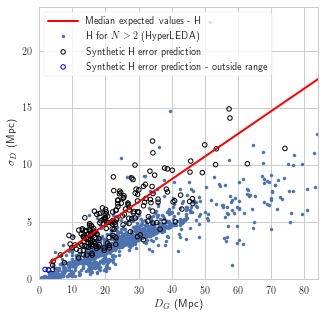

In [14]:
# This plot compares:
# original pre-computed HyperLEDA H errors for N>2
# projection of expected values from the linear model for NED-D H errors
# predicted H errors from the linear model for no-error galaxies
np.random.seed(10)
plt.figure(figsize=(5,5))
plt.scatter(x,y,s=10,label='H for $N>2$ (HyperLEDA)')
# Here we generate the synthetic H errors for no-error galaxies in HyperLEDA
xp=np.linspace(x1.min(),x1.max(),2)
modpar=samples1[np.random.randint(len(samples1))]
ymod=modpar[0]*meddist+modpar[1]
ysim=np.random.normal(ymod,modpar[2]*ymod)
mark='.'
plt.scatter(meddist[filt1],ysim[filt1], linewidth=1, facecolors='none', edgecolors='k',s=80,marker=mark,label='Synthetic H error prediction')
plt.scatter(meddist[~filt1],ysim[~filt1], linewidth=1, facecolors='none', edgecolors='b',s=80,marker=mark,label='Synthetic H error prediction - outside range')
plt.plot(xp,xp*sth1[0]+sth1[1],c='r',linewidth=2,label='Median expected values - H')
plt.xlim(0,meddist.max()+10)
plt.ylim(0,(xp*sth1[0]+sth1[1]).max()-5)
plt.legend(frameon=True,loc='upper left')
plt.xlabel('$D_G$ (Mpc)')
plt.ylabel('$\sigma_D$ (Mpc)')

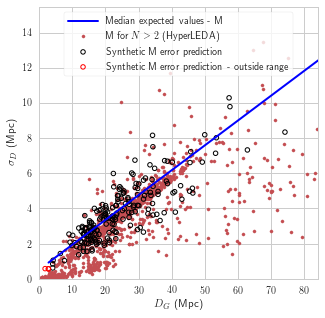

In [15]:
# This plot compares:
# original pre-computed HyperLEDA M errors for N>2
# projection of expected values from the linear model for NED-D H errors
# predicted H errors from the linear model for no-error galaxies
np.random.seed(10)
plt.figure(figsize=(5,5))
plt.scatter(x,z,c=current_palette[2],s=10,label='M for $N>2$ (HyperLEDA)')
# Here we generate the synthetic M errors for no-error galaxies in HyperLEDA
xp=np.linspace(x2.min(),x2.max(),2)
modpar=samples2[np.random.randint(len(samples2))]
ymod=modpar[0]*meddist+modpar[1]
ysim=np.random.normal(ymod,modpar[2]*ymod)
mark='.'
plt.scatter(meddist[filt2],ysim[filt2], linewidth=1, facecolors='none', edgecolors='k',s=80,marker=mark,label='Synthetic M error prediction')
plt.scatter(meddist[~filt2],ysim[~filt2], linewidth=1, facecolors='none', edgecolors='r',s=80,marker=mark,label='Synthetic M error prediction - outside range')
plt.plot(xp,xp*sth2[0]+sth2[1],c='b',linewidth=2,label='Median expected values - M')
plt.xlim(0,meddist.max()+10)
plt.ylim(0,(xp*sth2[0]+sth2[1]).max()-5)
plt.legend(frameon=True,loc='upper center')
plt.xlabel('$D_G$ (Mpc)')
plt.ylabel('$\sigma_D$ (Mpc)')

## This section deals with asymmetry in distance errors

In [16]:
x=np.array(dboot)
y8=np.array(boot84)
y1=np.array(boot16)
res=(y8-2*x+y1)/x
print('95 percent of all errors are less than ~',int(100*np.percentile(np.abs(res),95)), '% asymmetric')

95 percent of all errors are less than ~ 8 % asymmetric


In [18]:
num=2
filt=(em>2)
x=np.array(dboot)[filt]
y8=np.array(boot84)[filt]
y1=np.array(boot16)[filt]
resabs=(y8-2*x+y1)
print('95 percent of all errors (for galaxies with more than',2 ,'measurements) are less than ~',int(np.percentile(np.abs(resabs),95)), 'Mpc asymmetric')

95 percent of all errors (for galaxies with more than 2 measurements) are less than ~ 5 Mpc asymmetric
